Iñigo Martin Melero

## Participante 13

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_13_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


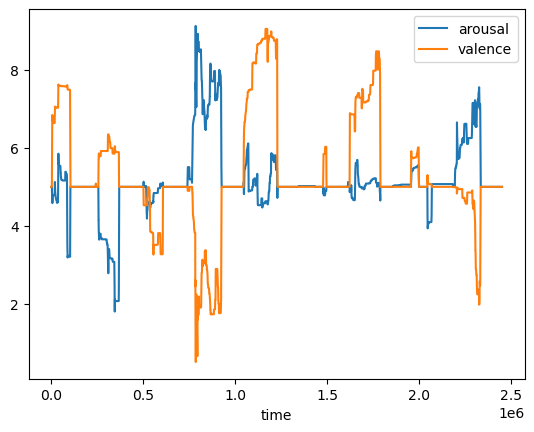

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_13_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.941  36.776  33.300  33.195  26.658     6.302     7.165   
1              1  0.941  36.893  33.174  33.186  26.665     6.302     7.165   
2              2  0.941  37.009  33.048  33.176  26.672     6.302     7.165   
3              3  0.945  37.106  33.242  33.195  26.669     6.425     7.328   
4              4  0.938  35.956  33.014  33.157  26.665     6.263     7.085   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.777  37.600  29.981  31.114  26.441    16.283     6.754   
2451580  2451580  0.771  37.332  29.749  31.104  26.441    16.201     6.714   
2451581  2451581  0.770  37.215  29.973  31.114  26.448    16.078     6.754   
2451582  2451582  0.774  37.377  30.097  31.114  26.448    15.995     6.754   
2451583  2451583  0.774  37.474  29.942  31.133  26.462    15.872     6.795   

         emg_trap  video  
0           9.628     10

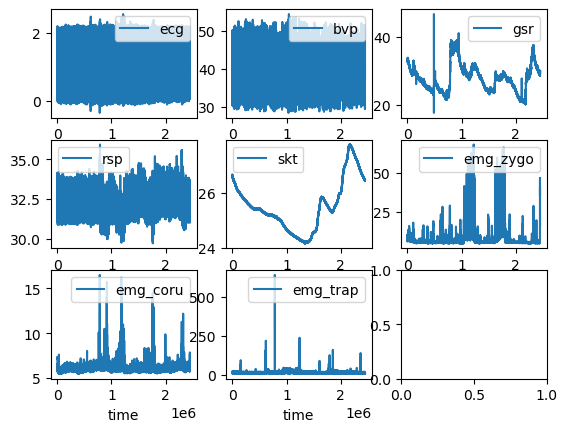

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

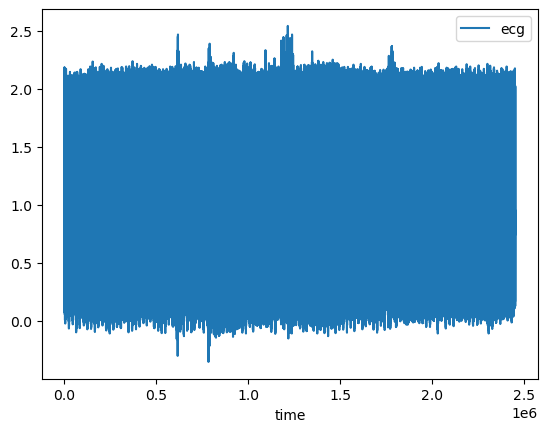

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

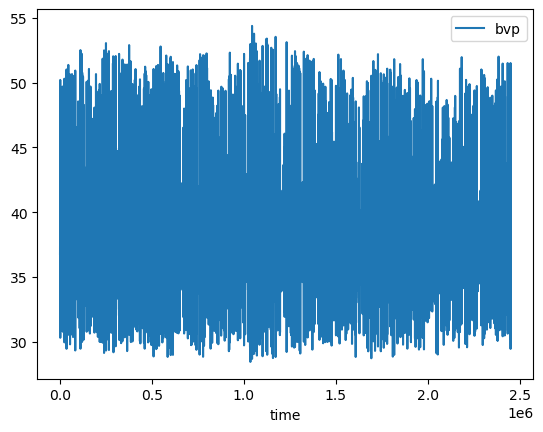

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

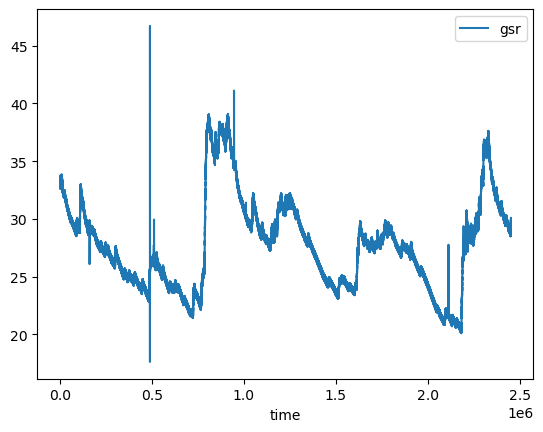

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

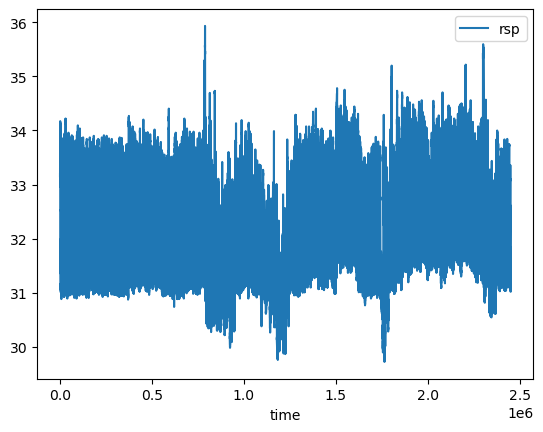

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

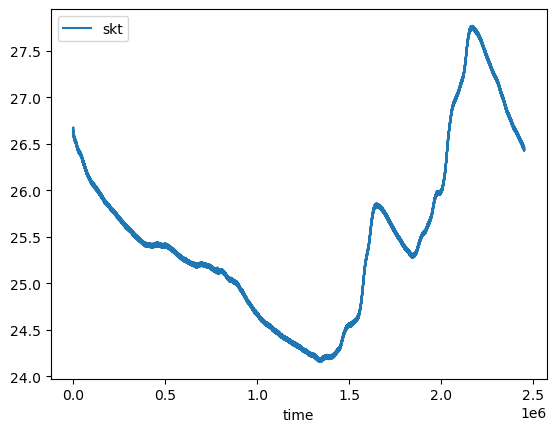

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

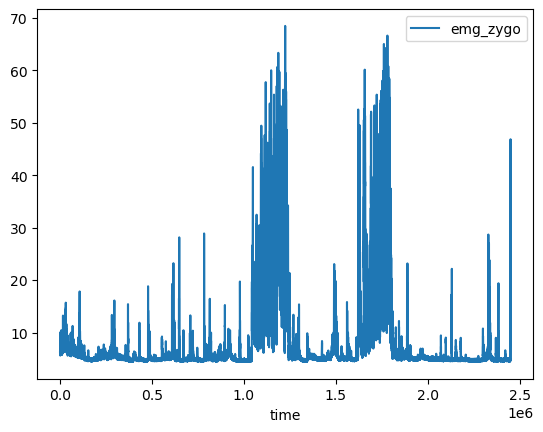

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

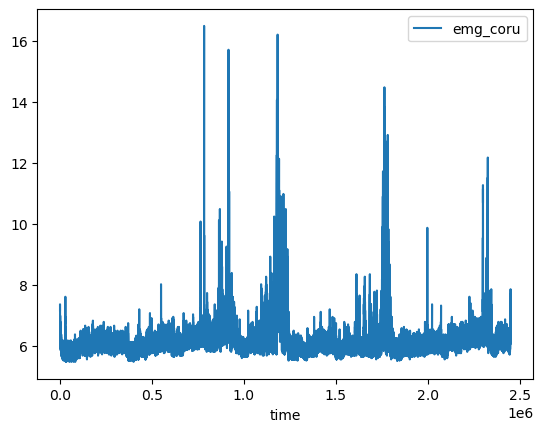

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

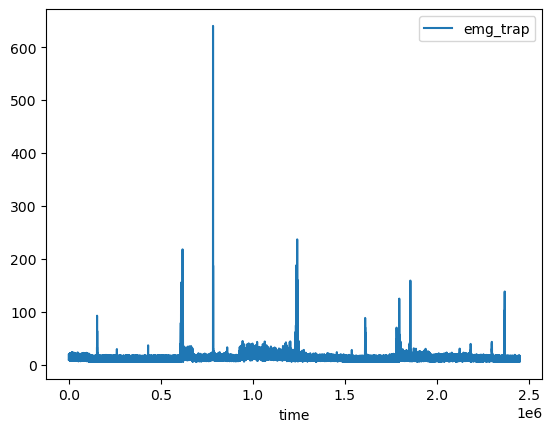

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

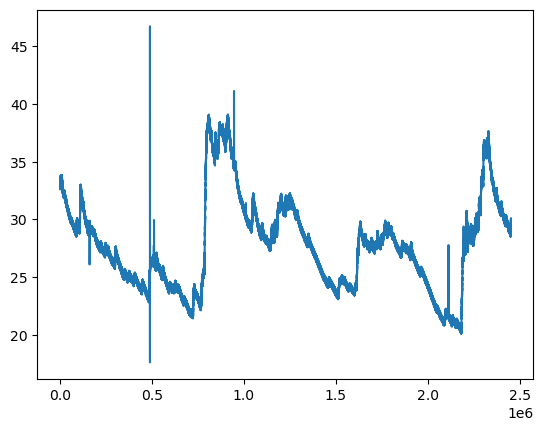

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

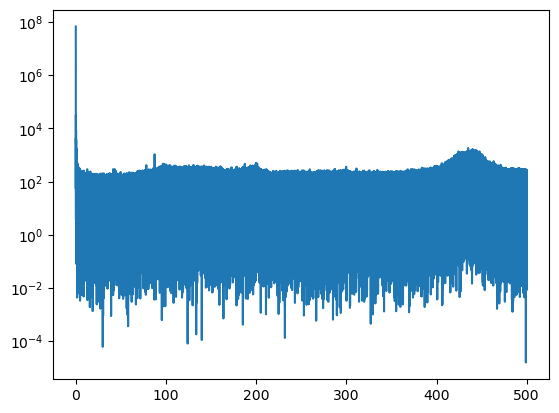

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  29.520
2451580  29.521
2451581  29.522
2451582  29.523
2451583  29.524

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

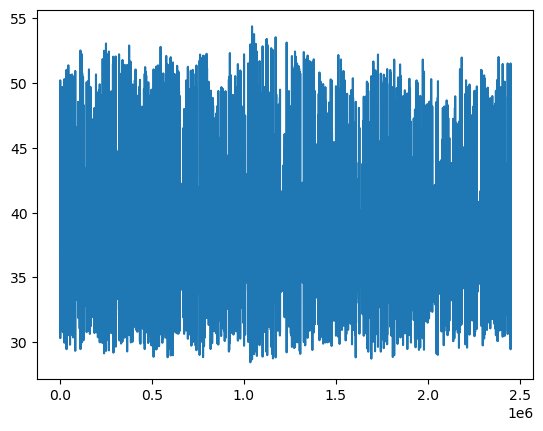

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.022
1        42.704
2        50.434
3        53.648
4        46.354
...         ...
2451579  37.061
2451580  37.055
2451581  37.034
2451582  36.982
2451583  36.929

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

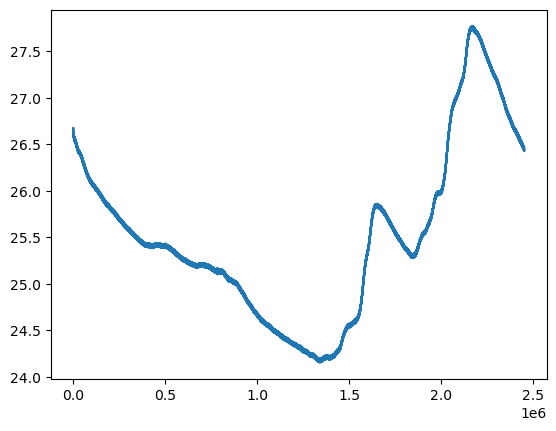

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

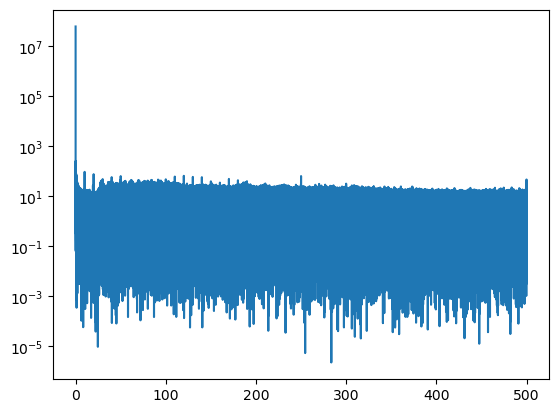

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

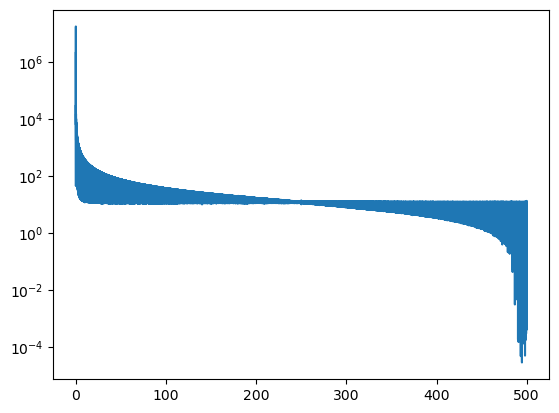

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.854
1        40.855
2        40.855
3        40.855
4        40.855
...         ...
2451579  16.475
2451580  16.479
2451581  16.484
2451582  16.488
2451583  16.493

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.941  33.195     6.302     7.165     9.628     10
1              1  0.941  33.186     6.302     7.165     9.670     10
2              2  0.941  33.176     6.302     7.165     9.711     10
3              3  0.945  33.195     6.425     7.328     9.955     10
4              4  0.938  33.157     6.263     7.085     9.754     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.777  31.114    16.283     6.754     7.329     12
2451580  2451580  0.771  31.104    16.201     6.714     7.289     12
2451581  2451581  0.770  31.114    16.078     6.754     7.329     12
2451582  2451582  0.774  31.114    15.995     6.754     7.370     12
2451583  2451583  0.774  31.133    15.872     6.795     7.411     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.941  33.195     6.302     7.165     9.628     10  38.022   
1              1  0.941  33.186     6.302     7.165     9.670     10  42.704   
2              2  0.941  33.176     6.302     7.165     9.711     10  50.434   
3              3  0.945  33.195     6.425     7.328     9.955     10  53.648   
4              4  0.938  33.157     6.263     7.085     9.754     10  46.354   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.777  31.114    16.283     6.754     7.329     12  37.061   
2451580  2451580  0.771  31.104    16.201     6.714     7.289     12  37.055   
2451581  2451581  0.770  31.114    16.078     6.754     7.329     12  37.034   
2451582  2451582  0.774  31.114    15.995     6.754     7.370     12  36.982   
2451583  2451583  0.774  31.133    15.872     6.795     7.411     12  36.929   

            gsr     skt  
0         0.000  40.854  
1         0.000  40.855  
2         0.000  40.855  
3         0.000  40.855  
4         0.000  40.855  
...         ...     ...  
2451579  29.520  16.475  
2451580  29.521  16.479  
2451581  29.522  16.484  
2451582  29.523  16.488  
2451583  29.524  16.493  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.797792  0.519457  0.358163  0.779489  0.448737  0.010895   
221502    221502  0.763975  0.520856  0.358163  0.779411  0.447127  0.010880   
221503    221503  0.735680  0.523654  0.358163  0.779346  0.447127  0.010239   
221504    221504  0.699448  0.526227  0.358163  0.779269  0.451795  0.010239   
221505    221505  0.652864  0.526955  0.358163  0.779191  0.451795  0.008957   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.423395  0.524941  0.885061  0.338104  0.417512  0.029482   
2331580  2331580  0.422360  0.522814  0.885061  0.338194  0.417512  0.028856   
2331581  2331581  0.424776  0.521472  0.885003  0.338272  0.419121  0.027575   
2331582  2331582  0.420290  0.523010  0.885003  0.338349  0.417512  0.028841   
2331583  2331583  0.415459  0.525668  0.885003  0.338440  0.414454  0.028841   

         emg_coru  emg_trap  video  
221501   0.056227  0.004397      5  
221502   0.045055  0.004271      5  
221503   0.048718  0.004397      5  
221504   0.048718  0.004526      5  
221505   0.041300  0.004335      5  
...           ...       ...    ...  
2331579  0.195330  0.004721      8  
2331580  0.195421  0.004786      8  
2331581  0.188004  0.004723      8  
2331582  0.195330  0.004721      8  
2331583  0.188004  0.004657      8  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.797792  0.519457  0.358163  0.448737  0.779489  0.010895   
221502    221502  0.763975  0.520856  0.358163  0.447127  0.779411  0.010880   
221503    221503  0.735680  0.523654  0.358163  0.447127  0.779346  0.010239   
221504    221504  0.699448  0.526227  0.358163  0.451795  0.779269  0.010239   
221505    221505  0.652864  0.526955  0.358163  0.451795  0.779191  0.008957   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.423395  0.524941  0.885061  0.417512  0.338104  0.029482   
2331580  2331580  0.422360  0.522814  0.885061  0.417512  0.338194  0.028856   
2331581  2331581  0.424776  0.521472  0.885003  0.419121  0.338272  0.027575   
2331582  2331582  0.420290  0.523010  0.885003  0.417512  0.338349  0.028841   
2331583  2331583  0.415459  0.525668  0.885003  0.414454  0.338440  0.028841   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
221540   0.334023  0.527878  0.358338  0.461130  0.776541  0.010223  0.041209   
221560   0.373706  0.523738  0.358396  0.465798  0.775028  0.007675  0.033791   
221580   0.383713  0.525444  0.358454  0.476742  0.773529  0.010239  0.044963   
221600   0.387164  0.524465  0.358454  0.483019  0.772003  0.010223  0.044963   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.327122  0.525976  0.886111  0.439401  0.331614  0.026934  0.112546   
2331520  0.317115  0.526116  0.885819  0.436182  0.333269  0.027559  0.157784   
2331540  0.332988  0.526647  0.885528  0.425398  0.334898  0.024354  0.116484   
2331560  0.397516  0.523458  0.885295  0.423789  0.336539  0.026293  0.184066   
2331580  0.422360  0.522814  0.885061  0.417512  0.338194  0.028856  0.195421   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1      0.334023  0.527878  0.358338  0.461130  0.776541  0.010223  0.041209   
2      0.373706  0.523738  0.358396  0.465798  0.775028  0.007675  0.033791   
3      0.383713  0.525444  0.358454  0.476742  0.773529  0.010239  0.044963   
4      0.387164  0.524465  0.358454  0.483019  0.772003  0.010223  0.044963   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.327122  0.525976  0.886111  0.439401  0.331614  0.026934  0.112546   
63500  0.317115  0.526116  0.885819  0.436182  0.333269  0.027559  0.157784   
63501  0.332988  0.526647  0.885528  0.425398  0.334898  0.024354  0.116484   
63502  0.397516  0.523458  0.885295  0.423789  0.336539  0.026293  0.184066   
63503  0.422360  0.522814  0.885061  0.417512  0.338194  0.028856  0.195421   

       emg_trap  valence  arousal  
0      0.013904    5.000    5.000  
1      0.018052    5.000    5.000  
2      0.012493    5.000    5.000  
3      0.007118    5.000    5.000  
4      0.004594    5.000    5.000  
...         ...      ...      ...  
63499  0.003429    2.470    7.131  
63500  0.003621    2.468    7.131  
63501  0.003298    2.465    7.131  
63502  0.003429    2.464    7.131  
63503  0.004786    2.464    7.131  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1      0.334023  0.527878  0.358338  0.461130  0.776541  0.010223  0.041209   
2      0.373706  0.523738  0.358396  0.465798  0.775028  0.007675  0.033791   
3      0.383713  0.525444  0.358454  0.476742  0.773529  0.010239  0.044963   
4      0.387164  0.524465  0.358454  0.483019  0.772003  0.010223  0.044963   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.405452  0.524745  0.887218  0.483019  0.325034  0.031420  0.169048   
63496  0.385093  0.526759  0.886927  0.469017  0.326675  0.028841  0.123901   
63497  0.362319  0.526955  0.886635  0.456462  0.328317  0.033327  0.101282   
63498  0.355418  0.524913  0.886344  0.450346  0.329972  0.032061  0.093773   
63499  0.327122  0.525976  0.886111  0.439401  0.331614  0.026934  0.112546   

       emg_trap  valence  arousal  
0      0.013904    5.000    5.000  
1      0.018052    5.000    5.000  
2      0.012493    5.000    5.000  
3      0.007118    5.000    5.000  
4      0.004594    5.000    5.000  
...         ...      ...      ...  
63495  0.003426    2.478    7.128  
63496  0.003104    2.475    7.129  
63497  0.003620    2.473    7.131  
63498  0.004206    2.471    7.131  
63499  0.003429    2.470    7.131  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
 1   0.334023  0.527878  0.358338  0.461130  0.776541  0.010223  0.041209   
 2   0.373706  0.523738  0.358396  0.465798  0.775028  0.007675  0.033791   
 3   0.383713  0.525444  0.358454  0.476742  0.773529  0.010239  0.044963   
 4   0.387164  0.524465  0.358454  0.483019  0.772003  0.010223  0.044963   
 5   0.386128  0.525164  0.358513  0.486078  0.770478  0.008973  0.037637   
 6   0.389579  0.526871  0.358513  0.489136  0.768952  0.008957  0.041209   
 7   0.385093  0.527570  0.358571  0.490906  0.767427  0.009582  0.048810   
 8   0.389579  0.526479  0.358571  0.501690  0.765901  0.008941  0.052473   
 9   0.387164  0.542453  0.358571  0.503300  0.764376  0.009598  0.048810   
 10  0.379227  0.526199  0.358571  0.507967  0.762850  0.009582  0.056227   
 11  0.365769  0.524997  0.358629  0.507967  0.761312  0.007066  0.052656   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1     0.396480  0.531291  0.359503  0.559311  0.739722  0.012146  0.067491   
2     0.363354  0.529137  0.359795  0.602929  0.701158  0.007660  0.052564   
3     0.467564  0.526255  0.359620  0.498471  0.663680  0.007644  0.052381   
4     0.415459  0.524941  0.358571  0.392564  0.628374  0.012162  0.060073   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.410973  0.524465  0.913272  0.244648  0.149046  0.116129  0.067491   
2536  0.417874  0.523598  0.917293  0.225978  0.178806  0.139186  0.052564   
2537  0.374741  0.527346  0.913621  0.302269  0.213311  0.054524  0.131410   
2538  0.400966  0.528438  0.905170  0.465958  0.251487  0.032702  0.112637   
2539  0.412008  0.521332  0.894271  0.556253  0.291990  0.034625  0.078846   

             8         9        10  ...       193       194       195  \
0     0.013904  0.334023  0.527878  ...  0.404417  0.523290  0.359445   
1     0.001226  0.396480  0.526759  ...  0.375776  0.518926  0.359795   
2     0.001228  0.347481  0.528298  ...  0.379227  0.528857  0.359620   
3     0.001291  0.839545  0.525108  ...  0.415459  0.525696  0.358629   
4     0.001291  0.408903  0.526955  ...  0.398551  0.528018  0.356822   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.003040  0.369220  0.529613  ...  0.425811  0.526535  0.917293   
2536  0.002263  0.403037  0.525584  ...  0.371291  0.528186  0.913854   
2537  0.003558  0.358868  0.523961  ...  0.407867  0.522031  0.905520   
2538  0.003686  0.377157  0.524465  ...  0.419945  0.525164  0.894737   
2539  0.003103  0.408903  0.526004  ...  0.327122  0.525976  0.886111   

           196       197       198       199       200  valence  arousal  
0     0.548527  0.741274  0.009614  0.056319  0.001098  5.00000  5.00000  
1     0.605987  0.702697  0.008285  0.052473  0.001484  5.00000  5.00000  
2     0.497022  0.665141  0.005753  0.041300  0.001163  5.00000  5.00000  
3     0.386448  0.629732  0.011521  0.063645  0.001354  5.00000  5.00000  
4     0.300660  0.597373  0.014084  0.048718  0.001744  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.229036  0.177513  0.088570  0.059890  0.001811  2.28312  7.01756  
2536  0.294544  0.211850  0.051319  0.105220  0.003688  2.55696  7.01600  
2537  0.458072  0.249897  0.035265  0.105128  0.003815  2.57800  7.01660  
2538  0.553034  0.290335  0.032061  0.086447  0.003038  2.57492  7.04736  
2539  0.439401  0.331614  0.026934  0.112546  0.003429  2.50848  7.11508  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1     0.396480  0.531291  0.359503  0.559311  0.739722  0.012146  0.067491   
2     0.363354  0.529137  0.359795  0.602929  0.701158  0.007660  0.052564   
3     0.467564  0.526255  0.359620  0.498471  0.663680  0.007644  0.052381   
4     0.415459  0.524941  0.358571  0.392564  0.628374  0.012162  0.060073   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.410973  0.524465  0.913272  0.244648  0.149046  0.116129  0.067491   
2536  0.417874  0.523598  0.917293  0.225978  0.178806  0.139186  0.052564   
2537  0.374741  0.527346  0.913621  0.302269  0.213311  0.054524  0.131410   
2538  0.400966  0.528438  0.905170  0.465958  0.251487  0.032702  0.112637   
2539  0.412008  0.521332  0.894271  0.556253  0.291990  0.034625  0.078846   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub13.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1     0.396480  0.531291  0.359503  0.559311  0.739722  0.012146  0.067491   
2     0.363354  0.529137  0.359795  0.602929  0.701158  0.007660  0.052564   
3     0.467564  0.526255  0.359620  0.498471  0.663680  0.007644  0.052381   
4     0.415459  0.524941  0.358571  0.392564  0.628374  0.012162  0.060073   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.410973  0.524465  0.913272  0.244648  0.149046  0.116129  0.067491   
2536  0.417874  0.523598  0.917293  0.225978  0.178806  0.139186  0.052564   
2537  0.374741  0.527346  0.913621  0.302269  0.213311  0.054524  0.131410   
2538  0.400966  0.528438  0.905170  0.465958  0.251487  0.032702  0.112637   
2539  0.412008  0.521332  0.894271  0.556253  0.291990  0.034625  0.078846   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub13.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1     0.396480  0.531291  0.359503  0.559311  0.739722  0.012146  0.067491   
2     0.363354  0.529137  0.359795  0.602929  0.701158  0.007660  0.052564   
3     0.467564  0.526255  0.359620  0.498471  0.663680  0.007644  0.052381   
4     0.415459  0.524941  0.358571  0.392564  0.628374  0.012162  0.060073   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.410973  0.524465  0.913272  0.244648  0.149046  0.116129  0.067491   
2536  0.417874  0.523598  0.917293  0.225978  0.178806  0.139186  0.052564   
2537  0.374741  0.527346  0.913621  0.302269  0.213311  0.054524  0.131410   
2538  0.400966  0.528438  0.905170  0.465958  0.251487  0.032702  0.112637   
2539  0.412008  0.521332  0.894271  0.556253  0.291990  0.034625  0.078846   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub13.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1     0.396480  0.531291  0.359503  0.559311  0.739722  0.012146  0.067491   
2     0.363354  0.529137  0.359795  0.602929  0.701158  0.007660  0.052564   
3     0.467564  0.526255  0.359620  0.498471  0.663680  0.007644  0.052381   
4     0.415459  0.524941  0.358571  0.392564  0.628374  0.012162  0.060073   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.410973  0.524465  0.913272  0.244648  0.149046  0.116129  0.067491   
2536  0.417874  0.523598  0.917293  0.225978  0.178806  0.139186  0.052564   
2537  0.374741  0.527346  0.913621  0.302269  0.213311  0.054524  0.131410   
2538  0.400966  0.528438  0.905170  0.465958  0.251487  0.032702  0.112637   
2539  0.412008  0.521332  0.894271  0.556253  0.291990  0.034625  0.078846   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub13.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.142512  0.526619  0.358221  0.450346  0.778054  0.008988  0.041300   
1     0.396480  0.531291  0.359503  0.559311  0.739722  0.012146  0.067491   
2     0.363354  0.529137  0.359795  0.602929  0.701158  0.007660  0.052564   
3     0.467564  0.526255  0.359620  0.498471  0.663680  0.007644  0.052381   
4     0.415459  0.524941  0.358571  0.392564  0.628374  0.012162  0.060073   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.410973  0.524465  0.913272  0.244648  0.149046  0.116129  0.067491   
2536  0.417874  0.523598  0.917293  0.225978  0.178806  0.139186  0.052564   
2537  0.374741  0.527346  0.913621  0.302269  0.213311  0.054524  0.131410   
2538  0.400966  0.528438  0.905170  0.465958  0.251487  0.032702  0.112637   
2539  0.412008  0.521332  0.894271  0.556253  0.291990  0.034625  0.078846   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub13.csv', index=False)